In [1]:
import os
import glob
from datetime import datetime

import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import map_coordinates
from scipy.stats import linregress
from matplotlib.colors import ListedColormap
from cmocean import cm as cmo

from cartopy.crs import LambertAzimuthalEqualArea
from cartopy.feature import LAND

laea = LambertAzimuthalEqualArea(central_longitude=0, central_latitude=-90)
%matplotlib inline

In [2]:
SIA_DIR = r"D:\SIA_Weddell_Sea"
#NSIDC_DIR = '/Volumes/sat_downloads/NSIDC_iceage'

def get_lmsia_data(year):
    idir = f'{SIA_DIR}/nc/{year}'
    ifile = glob.glob(f'{idir}/*1231.nc')[0]
    with Dataset(ifile) as ds:
        sia = ds.variables['sea_ice_age'][0]
        x = ds.variables['x'][:]
        y = ds.variables['y'][:]
        status_flag = ds.variables['status_flag'][0]
        conc = []
        for i in range(1, 8):
            if f'conc_{i}yi' in ds.variables:
                conc.append(ds.variables[f'conc_{i}yi'][0])
    conc = np.array(conc)[::-1]
    land = np.where(status_flag == 2, 1, np.nan)
    return sia, x, y, land, conc

#def get_nsidc_data(year):
 #   ifile = f'{NSIDC_DIR}/iceage_nh_12.5km_{year}0101_{year}1231_v4.1.nc'
  #  if os.path.exists(ifile):
   #     with Dataset(ifile) as ds:
    #        age_of_sea_ice = ds.variables['age_of_sea_ice'][-1]
     #       nsidc_x = ds.variables['x'][:]
      #      nsidc_y = ds.variables['y'][:]

       # nsidc_age = np.where(age_of_sea_ice == 0, np.nan, age_of_sea_ice)
        #nsidc_land = np.where(age_of_sea_ice == 20, 1, np.nan)
        #nsidc_age[nsidc_age >= 20] = np.nan
        #return nsidc_age, nsidc_x, nsidc_y, nsidc_land
   # else:
    #    return None, None, None, None

In [ ]:
class GetIceType:
    def __init__(self):
        self.x = None
        self.y = None
        self.url_cdr = 'https://thredds.met.no/thredds/dodsC/c3s/cdr_ice_type_v4p0_files/%Y/%m/ice_type_nh_ease2-250_cdr-v4p0_%Y%m%d1200.nc'
        self.url_icdr = 'https://thredds.met.no/thredds/dodsC/c3s/icdr_ice_type_v3p0_files/%Y/%m/ice_type_nh_ease2-250_icdr-v3p0_%Y%m%d1200.nc'

    def __call__(self, date):
        if date.year < 2021:
            url = date.strftime(self.url_cdr)
        else:
            url = date.strftime(self.url_icdr)
        try:
            with Dataset(url) as ds:
                ice_type = ds.variables['ice_type'][0].astype(float).filled(np.nan)
                if self.x is None or self.y is None:
                    # Only read the coordinates once
                    # to save time and memory
                    self.x = ds.variables['xc'][:] * 1000
                    self.y = ds.variables['yc'][:] * 1000
        except OSError:
            print(f'File not found: {url}')
            return None
        return ice_type
    
get_ice_type = GetIceType()

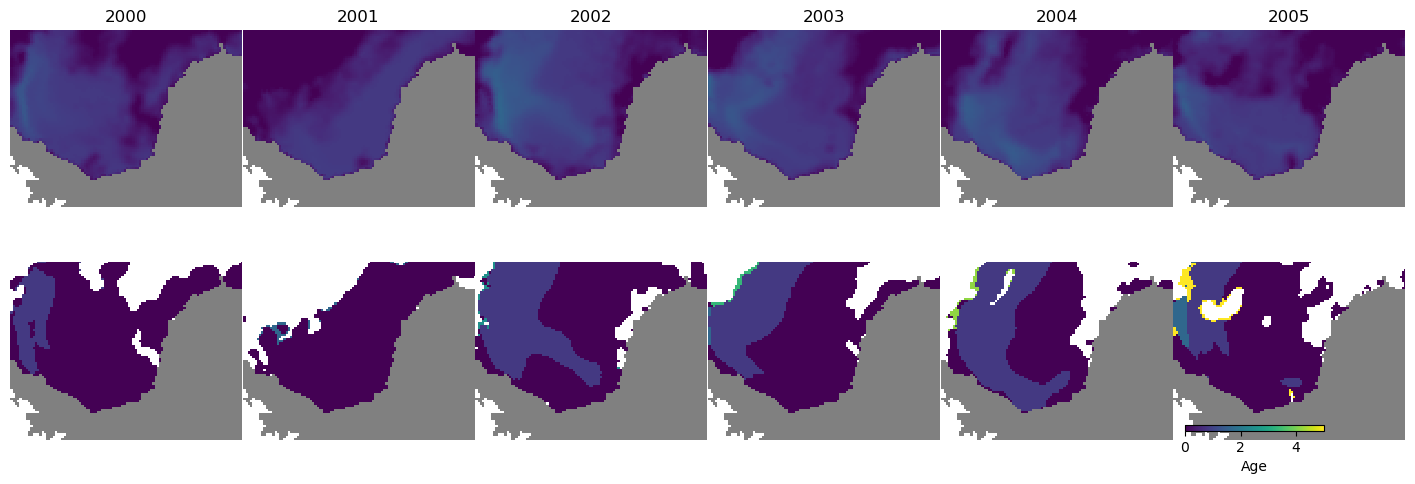

In [18]:
min_conc = 0.15
#years = [1995, 2000, 2005, 2010, 2015, 2020, 2024]
years = [2000, 2001, 2002, 2003, 2004, 2005]

fig, axs = plt.subplots(2, len(years), figsize=(3 * len(years), 6))
for iyear, year in enumerate(years):
    sia, x, y, land, conc = get_lmsia_data(year)

    tot_conc = np.sum(conc, axis=0)
    max_age = len(conc) - np.argmax(conc > min_conc, axis=0).astype(float)
    max_age[(tot_conc < min_conc) + np.isnan(tot_conc)] = np.nan

    imsh_age = axs[0, iyear].imshow(sia, cmap='viridis', clim=[0, 5], extent=[x[0], x[-1], y[-1], y[0]], interpolation='none')
    axs[0, iyear].imshow(land, cmap='gray', clim=[0, 2], extent=[x[0], x[-1], y[-1], y[0]], interpolation='none')

    axs[1, iyear].imshow(max_age, cmap='viridis', clim=[1, 7], extent=[x[0], x[-1], y[-1], y[0]], interpolation='none')
    axs[1, iyear].imshow(land, cmap='gray', clim=[0, 2], extent=[x[0], x[-1], y[-1], y[0]], interpolation='none')

    #nsidc_age, nsidc_x, nsidc_y, nsidc_land = get_nsidc_data(year)
    #if nsidc_age is not None:
    #    axs[2, iyear].imshow(nsidc_age, extent=[nsidc_x[0], nsidc_x[-1], nsidc_y[-1], nsidc_y[0]], cmap='viridis', clim=[1, 7], interpolation='none')
    #    axs[2, iyear].imshow(nsidc_land, cmap='gray', extent=[nsidc_x[0], nsidc_x[-1], nsidc_y[-1], nsidc_y[0]], clim=[0,2], interpolation='none')
    
    #ice_type = get_ice_type(datetime(year, 12, 31))
    #if ice_type is not None:
    #    accent4 = ListedColormap(plt.cm.Accent.colors[:5])
    #    imsh_type = axs[3, iyear].imshow(ice_type, cmap=accent4, clim=[0, 4], extent=[x[0], x[-1], y[-1], y[0]], interpolation='none')
    #    #imsh_type = axs[3, iyear].imshow(ice_type, cmap='Accent', clim=[0, 4], extent=[x[0], x[-1], y[-1], y[0]], interpolation='none')
    #   axs[3, iyear].imshow(land, cmap='gray', clim=[0, 2], extent=[x[0], x[-1], y[-1], y[0]], interpolation='none')
     #   icetype_mask = np.where(np.isfinite(ice_type), 0, 1)

    axs[0, iyear].set_title(year)
    

for ax in axs.flat:
    ax.set_xlim([-2.4e6, 2.1e5])
    ax.set_ylim([0.5e6, 2.5e6])
    ax.set_axis_off()

cax1 = axs[1, -1].inset_axes([0.05, 0.05, 0.6, 0.03])
plt.colorbar(imsh_age, cax=cax1, label='Age', orientation='horizontal')

# Colorbar for age (axs[2, 6])
#cax1 = axs[1, 6].inset_axes([.1, 0.1 ])#0.07, 0.8
#plt.colorbar(imsh_age, cax=cax1, label='Age')

#cax2 = axs[2, 6].inset_axes([.5, 0.1]) # 0.07, 0.8]
#cbar_type = plt.colorbar(imsh_type, cax=cax2, label='Type')
plt.subplots_adjust(hspace=0.01, wspace=0.005)
plt.savefig('figure10_sia_age_type.png', dpi=100, bbox_inches='tight', pad_inches=0.1)

In [ ]:
year = 2020

sia, x, y, land, conc = get_lmsia_data(year)

nsidc_age, nsidc_x, nsidc_y, nsidc_land = get_nsidc_data(year)
nsidc_pixel_area = np.mean(np.diff(nsidc_x) * np.diff(nsidc_y)) / 1e6 # km2
print(f'NSIDC pixel area: {nsidc_pixel_area:.2f} km2')

ice_type = get_ice_type(datetime(year, 12, 31))
icetype_mask = np.where(np.isfinite(ice_type), 0, 1)

rows, cols = np.mgrid[0:sia.shape[0], 0:sia.shape[1]]
rgi_rows = RegularGridInterpolator((y, x), rows, method='nearest', bounds_error=False, fill_value=None)
rgi_cols = RegularGridInterpolator((y, x), cols, method='nearest', bounds_error=False, fill_value=None)
rows_nsidc = rgi_rows((np.meshgrid(nsidc_y, nsidc_x, indexing='ij')))
cols_nsidc = rgi_cols((np.meshgrid(nsidc_y, nsidc_x, indexing='ij')))

land_pro = map_coordinates(np.where(land == 1, 1, 0), (rows_nsidc, cols_nsidc), order=0, mode='nearest')
conc_mask_pro = map_coordinates(np.where(np.isfinite(conc[0]), 0, 1), (rows_nsidc, cols_nsidc), order=0, mode='nearest')
nsidc_land_int = np.where(nsidc_land == 1, 1, 0)
icetype_mask_pro = map_coordinates(icetype_mask, (rows_nsidc, cols_nsidc), order=0, mode='nearest')

joint_flag = nsidc_land_int + 2 * land_pro + 4 * conc_mask_pro + 8 * icetype_mask_pro
# water or sea ice processed on both NSIDC and LMSIA datasets at NSIDC resolution
valid_mask = joint_flag == 0
plt.imshow(valid_mask, interpolation='nearest')
plt.colorbar()

In [ ]:
sia_areas_ts = []
nsidc_area_ts = []
icetype_areas_ts = []
years = range(1995, 2025)
for year in years:
    sia, x, y, land, conc = get_lmsia_data(year)
    nsidc_age, nsidc_x, nsidc_y, nsidc_land = get_nsidc_data(year)
    conc_pro = np.array([
        map_coordinates(c, (rows_nsidc, cols_nsidc), order=0, mode='nearest')
        for c in conc
    ])
    conc_pro[:, ~valid_mask] = np.nan
    sia_areas = np.nansum(conc_pro, axis=(1, 2))
    # add zero to the first year
    if sia_areas.size == 6:
        sia_areas = np.hstack([0, sia_areas])
    if nsidc_age is not None:
        nsidc_age[~valid_mask] = np.nan
        nsidc_age_areas = np.diff([(nsidc_age >= i).sum() for i in range(1, 9)][::-1])
    else:
        nsidc_age_areas = np.zeros(7) + np.nan
    
    ice_type = get_ice_type(datetime(year, 12, 31))
    if ice_type is not None:
        ice_type_pro = map_coordinates(ice_type, (rows_nsidc, cols_nsidc), order=0, mode='nearest')
        ice_type_pro[~valid_mask] = np.nan
        ice_type_areas = np.array([(ice_type_pro == i).sum() for i in range(1,5)])
    else:
        ice_type_areas = np.zeros(4) + np.nan

    sia_areas_ts.append(sia_areas)
    nsidc_area_ts.append(nsidc_age_areas)
    icetype_areas_ts.append(ice_type_areas)
    
sia_areas_ts = np.array(sia_areas_ts).T * nsidc_pixel_area
nsidc_area_ts = np.array(nsidc_area_ts).T * nsidc_pixel_area
icetype_areas_ts = np.array(icetype_areas_ts).T * nsidc_pixel_area

In [ ]:
icetype_TOT_area = icetype_areas_ts[1] + icetype_areas_ts[2] +  icetype_areas_ts[3]
icetype_MYI_area = icetype_areas_ts[2]
icetype_FYI_area = icetype_areas_ts[1]


# Plot the time series as a stacked bar plot
fig, ax = plt.subplots(figsize=(10, 3))

# Create labels for age classes
age_labels = ['1YI', '2YI', '3YI', '4YI', '5YI', '6YI', 'OLD'][::-1]

# Create x-axis for years
x = np.array(list(years))

# Create a stacked bar plot
bottom = np.zeros(len(years))
bars = []
colors = plt.cm.viridis(np.linspace(0, 1, sia_areas_ts.shape[0]))
for i, age_data in enumerate(sia_areas_ts):
    bars.append(ax.bar(x-0.2, age_data, bottom=bottom, label=age_labels[i], color=colors[i], width=0.3))
    bottom += age_data

bottom = np.zeros(len(years))
bars = []
colors = plt.cm.viridis(np.linspace(0, 1, sia_areas_ts.shape[0]))
for i, age_data in enumerate(nsidc_area_ts):
    bars.append(ax.bar(x+0.2, age_data, bottom=bottom, color=colors[i], width=0.3))
    bottom += age_data

ax.plot(x, icetype_TOT_area, '-', label='Total (SIType)', color='black', linewidth=1)
ax.plot(x, icetype_MYI_area, '--', label='MYI (SIType)', color='black', linewidth=1)

# Add labels and title
ax.set_ylabel('Area, km²', fontsize=12)
ax.set_title('Sea Ice Area by Age Class (1995-2024)', fontsize=14)

# Add legend
ax.legend(loc='upper right')

# Add grid
ax.grid(True, linestyle='--', alpha=0.7)

ax.set_xlim([1994, 2030])
# Adjust x-axis ticks to show every 3 years
plt.xticks(x, rotation=90)

plt.tight_layout()
plt.savefig('figure11_sia_age_ts.png', dpi=100, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
sia_areas_ts_dict = {
    'FYI': sia_areas_ts[-1],
    'MYI': sia_areas_ts[:-1].sum(axis=0),
}
for i in range(1, 7):
    sia_areas_ts_dict[f'{i+1}YI'] = sia_areas_ts[::-1][i]

nsidc_areas_ts_dict = {
    'FYI': nsidc_area_ts[-1],
    'MYI': nsidc_area_ts[:-1].sum(axis=0),
}
for i in range(1, 7):
    nsidc_areas_ts_dict[f'{i}YI'] = nsidc_area_ts[::-1][i]    

ice_type_areas_ts_dict = {
    'FYI': icetype_FYI_area,
    'MYI': icetype_MYI_area,
}

In [ ]:
labels = ['FYI', 'MYI', '2YI', '3YI', '4YI', '5YI', '6YI']#, '7YI']
colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))
slope_labels = ['LM-SIA', 'NSIDC', 'Ice Type']

years_arr = np.array(list(years))

fig, axs = plt.subplots(1, 4, figsize=(15,4))
slopes = [{}, {}, {}]
pvalues = [{}, {}, {}]
for j, areas_ts in enumerate([sia_areas_ts_dict, nsidc_areas_ts_dict, ice_type_areas_ts_dict]):
    # Plot sia_areas_ts and trendlines for each fraction
    for i, label in enumerate(labels):
        if label not in areas_ts:
            continue
        l = axs[j].plot(years_arr, areas_ts[label], '.', label=label)
        # Only fit where data is finite
        mask = np.isfinite(areas_ts[label]) * (areas_ts[label] > 0)
        slope, intercept, r_value, p_value, std_err = linregress(years_arr[mask], areas_ts[label][mask])
        axs[j].plot(years_arr, intercept + slope * years_arr, '--', color=l[0].get_color())
        slopes[j][label] = slope
        pvalues[j][label] = p_value

styles = ['.', 'x', 'v']
slope_lines = []
for i, slope_label in enumerate(slope_labels):
    for j, label in enumerate(labels):
        if label not in slopes[i]:
            continue
        slope = slopes[i][label]
        pvalue = pvalues[i][label]
        if pvalue > 0.05:
            slope_line = axs[3].plot(j, slope, f'k{styles[i]}', alpha=0.3)[0]
        else:
            slope_line = axs[3].plot(j, slope, f'k{styles[i]}')[0]
        if j == 0:
            slope_lines.append(slope_line)


axs[0].set_xlim([1994, 2030])
axs[3].set_xticks([0,1,2,3,4,5,6])#,7])
axs[3].set_xticklabels(['FYI', 'MYI', '2YI', '3YI', '4YI', '5YI', '6YI'])#, 'OLD'])
axs[0].set_title('LM SIA')
axs[1].set_title('NSIDC')
axs[2].set_title('Ice Type')
axs[3].set_title('Slope of trendlines')
axs[0].set_ylabel('Area, km²', fontsize=12)
axs[0].set_xlabel('Year', fontsize=12)
axs[1].set_xlabel('Year', fontsize=12)
axs[2].set_xlabel('Year', fontsize=12)
axs[0].set_ylim([0, 6e6])
axs[1].set_ylim([0, 6e6])
axs[2].set_ylim([0, 6e6])

axs[3].set_ylabel('Trend, km$^2$ y$^{-1}$', fontsize=12)
axs[3].set_xlabel('Age Class', fontsize=12)
axs[3].grid(True, linestyle='--', alpha=0.7)

axs[0].legend(loc='upper right', fontsize=7)
axs[3].legend(slope_lines, slope_labels)

plt.tight_layout(h_pad=0.1)
plt.savefig('figure12_sia_age_ts_trends.png', dpi=100, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
min_conc = 0.05

sia_avg_age_ts = []
sia_max_age_ts = []
nsidc_age_ts = []
years = range(1995, 2025)
for year in years:
    print(year)
    sia, x, y, land, conc = get_lmsia_data(year)
    conc_pro = np.array([
        map_coordinates(c, (rows_nsidc, cols_nsidc), order=0, mode='nearest')
        for c in conc
    ])
    sia_pro = map_coordinates(sia, (rows_nsidc, cols_nsidc), order=0, mode='nearest')
    conc_pro[:, ~valid_mask] = np.nan
    sia_pro[~valid_mask] = np.nan
    tot_conc = np.sum(conc_pro, axis=0)
    max_age = len(conc_pro) - np.argmax(conc_pro > min_conc, axis=0).astype(float)
    max_age[(tot_conc < min_conc) + np.isnan(tot_conc)] = np.nan

    sia_avg_age_ts.append(sia_pro)
    sia_max_age_ts.append(max_age)
    
    nsidc_age, nsidc_x, nsidc_y, nsidc_land = get_nsidc_data(year)
    if nsidc_age is not None:
        nsidc_age[~valid_mask] = np.nan
    else:
        nsidc_age = np.zeros_like(max_age) + np.nan
    nsidc_age_ts.append(nsidc_age)

    

In [ ]:
nsidc_age_ts = np.array(nsidc_age_ts)
sia_avg_age_ts = np.array(sia_avg_age_ts)
sia_max_age_ts = np.array(sia_max_age_ts)
sia_avg_age_ts.shape, sia_max_age_ts.shape, nsidc_age_ts.shape

In [ ]:
trends = []
pvals = []
for sia in[sia_avg_age_ts, sia_max_age_ts, nsidc_age_ts]:
    # Prepare arrays for trend (slope) and p-value
    trend = np.full((sia.shape[1], sia.shape[2]), np.nan, dtype=np.float32)
    pval = np.full((sia.shape[1], sia.shape[2]), np.nan, dtype=np.float32)

    # Time axis as float (e.g., years)
    years_matrix = None

    # Loop over all pixels
    for i in range(1, sia.shape[1]-3):
        for j in range(1, sia.shape[2]-3):
            sia_sub = sia[:, i-1:i+2, j-1:j+2]
            if years_matrix is None:
                years_matrix = np.broadcast_to(np.array(years)[:, None, None], sia_sub.shape)
            mask = ~np.isnan(sia_sub)
            if np.count_nonzero(mask) > 10:
                slope, intercept, _, p, _ = linregress(years_matrix[mask], sia_sub[mask])
                trend[i, j] = slope
                pval[i, j] = p
                #if p < 0.01:
                #    raise
    trends.append(trend)
    pvals.append(pval)
    # trend and pval now contain the pixelwise linear trend and p-value

In [ ]:
nsidc_age, nsidc_x, nsidc_y, nsidc_land = get_nsidc_data(1995)

In [ ]:
cmins = [-1, -3, -4]
cmins = [-4, -4, -4]
cmap = cmo.deep_r
titles = ['(a) Average LM-SIAge', '(b) Maximum LM-SIAge', '(c) NSIDC Age']

axs = []
fig = plt.figure(figsize=(15, 5))
for i, (trend, pval, cmin) in enumerate(zip(trends, pvals, cmins)):
    ax = fig.add_subplot(1, 3, i+1, projection=laea)
    trend_tmp = np.array(trend)
    trend_tmp[pval > 0.05] = np.nan  # Mask out non-significant trends
    trend_myi = trend[nsidc_age > 2]
    median_trend = np.nanmedian(trend_myi) * 12

    imsh0 = ax.imshow(trend_tmp*12, clim=[cmin, 0], extent=[nsidc_x[0], nsidc_x[-1], nsidc_y[-1], nsidc_y[0]], cmap=cmap, interpolation='none')
    #plt.colorbar(imsh0, ax=ax, orientation='vertical', shrink=0.5)
    ax.set_title(titles[i] + f', $\\mu={median_trend:.2f}$ month y$^-$$^1$')
    ax.add_feature(LAND, facecolor='lightgray', edgecolor='black', zorder=1)
    axs.append(ax)

for ax in axs:
    ax.set_xlim([-1.9e6, 2.1e6])
    ax.set_ylim([-2.35e6, 2.5e6])
    ax.set_axis_off()
    # Add a horizontal colorbar spanning all three subplots
    cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.03])
    cbar = fig.colorbar(imsh0, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Trend (months/year)')
plt.savefig('figure13_sia_age_trends.png', dpi=100, bbox_inches='tight', pad_inches=0.1)
plt.show()